## Deep Learning Assignment - Identification of household water end-uses


Welcome to the assignment for Week 8 of your Applied Machine Learning course. In this assigment, you will be tasked with _classifying water end-uses from smart water meter data_ using Deep Learning techniques. 

<u> Background </u>

With the progressive digitalization of the water sector, many residential buildings around the world have now smart water meters installed to measure water consumption. While this information is mainly used for billing purposes, water utilities are figuring out ways to employ this data for implementing sustainable water management strategies. After addressing relevant privacy and ethical issues, analysts can use high-resolution smart meter recordings to identify consumer behaviours and detect leaks occurring within the building. This in turn can lead to substantial water savings.

While installing a smart water meter in a household is rather easy, accurate mapping of consumer behaviour entails breaking down the total household water consumption (measured by the smart meter) into **water end-uses**, such as water used for faucets, toilets, showers, washing machines, lawn irrigation, etc. Understanding these end-uses will enable water utilities and household owners to determine where water is wasted, how much and how often, and plan strategies to optimize consumption or identify leaks. 

To perform this _disaggregation_, analyst usually resort to surveys and checklists, where they ask volunteer households to keep track of their individual consumptions for days as their total consumption is recorded. An alternative approach would be to monitor at the same time total consumption with a smart water meter along with (all) individual end-uses with less intrusive flow meters, as illustrated in Figure 1. This setting enables gathering high-resolution and more accurate data. 

<center><figure>
  <img src="https://drive.google.com/uc?id=18PhgHUTbkxIIpi7Q7zY6q_u3_jjUlWSX" width=600/>
<figcaption>Figure 1. Household with collective smart water meter and water end-uses flow meters. 

<sub><sup>Image credits to https://droughtresources.unl.edu/household-water-use, lcongeek26 and Good Ware from www.flaticon.com. </sup></sub></figcaption>
</figure></center>

<u> Problem defintion </u>

A water utility has carried out an extensive water monitoring campaign involving several households. Following the scheme of Figure 1, smart water meters (totalizers) and individual flow meters have been installed for six common end-uses/appliances:
- Toilet;
- Shower;
- Faucets (taps of different kinds);
- Clotheswasher;
- Dishwasher;
- Bathub.

As an analyst of the water utility, your task is to develop an AI-based tool that can perform the multi-class classification shown in Figure 2. Your system will process sequences of readings from the smart water meter, recognize the _signature_ of the particular end-use, and assign it to one of the possible classes. You will develop this tool in a _supervised learning_ manner by employing the labeled datasets made available during the monitoring campaign. If your system generalizes well to unseen data, the water utility will include it in an app for its customers, to allow them to monitor their own consumptions and identify leaks via automatic processing of their smart water meter readings.


<center><figure>
  <img src="https://drive.google.com/uc?id=1gDQeE38Q5AZBBIlmCgSdIOxmgV0XyaAX" width=800/>
<figcaption>Figure 2. Multi-class classification of end-use signature.</figcaption>
</figure></center>

<u> Dataset details </u>

The dataset you will use is created using STREaM, a realistic generator of residential water end-uses (https://github.com/acominola/STREaM). For simplicity, the data does not include water leakages in the pipes or simultaneous occurrance of multiple end-uses. Time series are recorded with a sampling rate of 10 seconds. In the next section, the original dataset is partially illustrated, before the actual *training*, *validation* and *test* dataset are created. The inputs will be made of 10 minutes long **sequences** of smart water meter recordings, that is 60 datapoints spaced at 10 seconds (lenght of sequence _L=60_). The outputs will be **one-hot encoded arrays**, that is vectors with all zeros apart from a single end-use. 

---
---


#### Link to Google Drive and Load python modules

# link to Google Drive to access files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive 

In [1]:
# generic modules
import datetime, os
import itertools
import time

# append working folder


# basic data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.optimizers.legacy import Adam
#Arash added
from tensorflow.keras import regularizers
#
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import tensorflow_addons as tfa
import tensorflow as tf
from keras.utils import plot_model

# sklearn helper functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# import additional helper scripts 
# [NOTE: USE THESE FUNCTIONS, IF YOU WANT, TO COMPUTE THE NUMBER OF WEIGHTS OF ANNs AND PLOT THE CONFUSION MATRIX]
from assignment_utils import *

#### Load original and visualize dataset

<AxesSubplot: >

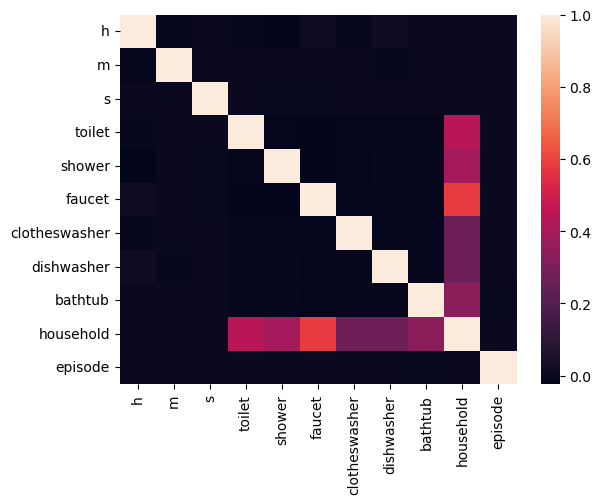

In [2]:
# load data
filename = 'household_water_consumption_identification.csv'
df = pd.read_csv(filename)

#investigating the correlation among different variables involved
sns.heatmap(df.corr())

In [4]:
#printing the data type of  the dataframe
print(df.dtypes)

h                  int64
m                  int64
s                  int64
toilet           float64
shower           float64
faucet           float64
clotheswasher    float64
dishwasher       float64
bathtub          float64
household        float64
episode            int64
dtype: object


## Arash added part
below, I analyzed the imported dataset

In [5]:
#analysing the dataset
def infoDataSet(dataset):
    print('---'*10)
    print(f'the size of dataset is (row * column)\n {dataset.size}')
    print('---'*10)
    print(f'the shape of shape is\n {dataset.shape}')
    print('---'*10)
    print(f'the number of unique values\n {dataset.nunique()}')
    print('---'*10)
    #to check whther is tehre any Nan value in teh dataset or not
    print(f'the number of nan values \n{dataset.isna().sum()}')
    print('---'*10)
    print(f'the number of unique values\n {dataset.dtypes}')
    
infoDataSet(df)

    

------------------------------
the size of dataset is (row * column)
 50845080
------------------------------
the shape of shape is
 (4622280, 11)
------------------------------
the number of unique values
 h                   24
m                   60
s                    6
toilet             356
shower             235
faucet             339
clotheswasher      362
dishwasher         298
bathtub            388
household          435
episode          77038
dtype: int64
------------------------------
the number of nan values 
h                0
m                0
s                0
toilet           0
shower           0
faucet           0
clotheswasher    0
dishwasher       0
bathtub          0
household        0
episode          0
dtype: int64
------------------------------
the number of unique values
 h                  int64
m                  int64
s                  int64
toilet           float64
shower           float64
faucet           float64
clotheswasher    float64
dishwasher   

The original dataset is in tabular form. The columns contain information on:
- the timestamp of each recording (no date, only time in hour, minutes, seconds);
- the volume of water at each timestamp for each water end-use;
- the overal volume of water consumed by the _household_ in that timestamp;
- the _episode_ (10 minutes long sequence) to which the recording belongs.

In [7]:
# water end-uses/appliances
end_uses = ['toilet','shower','faucet','clotheswasher','dishwasher','bathtub']
print(f'there are {len(end_uses)} end users')

there are 6 end users


Let us quickly visualize typical singatures for each end use. 

<u>Run the cell below multiple times with a differen random seed to see different events for each water end-use</u>.

<sub>_Note:_ Is not important if you do not understand everything the code below; focus on the visualized results.</sub>

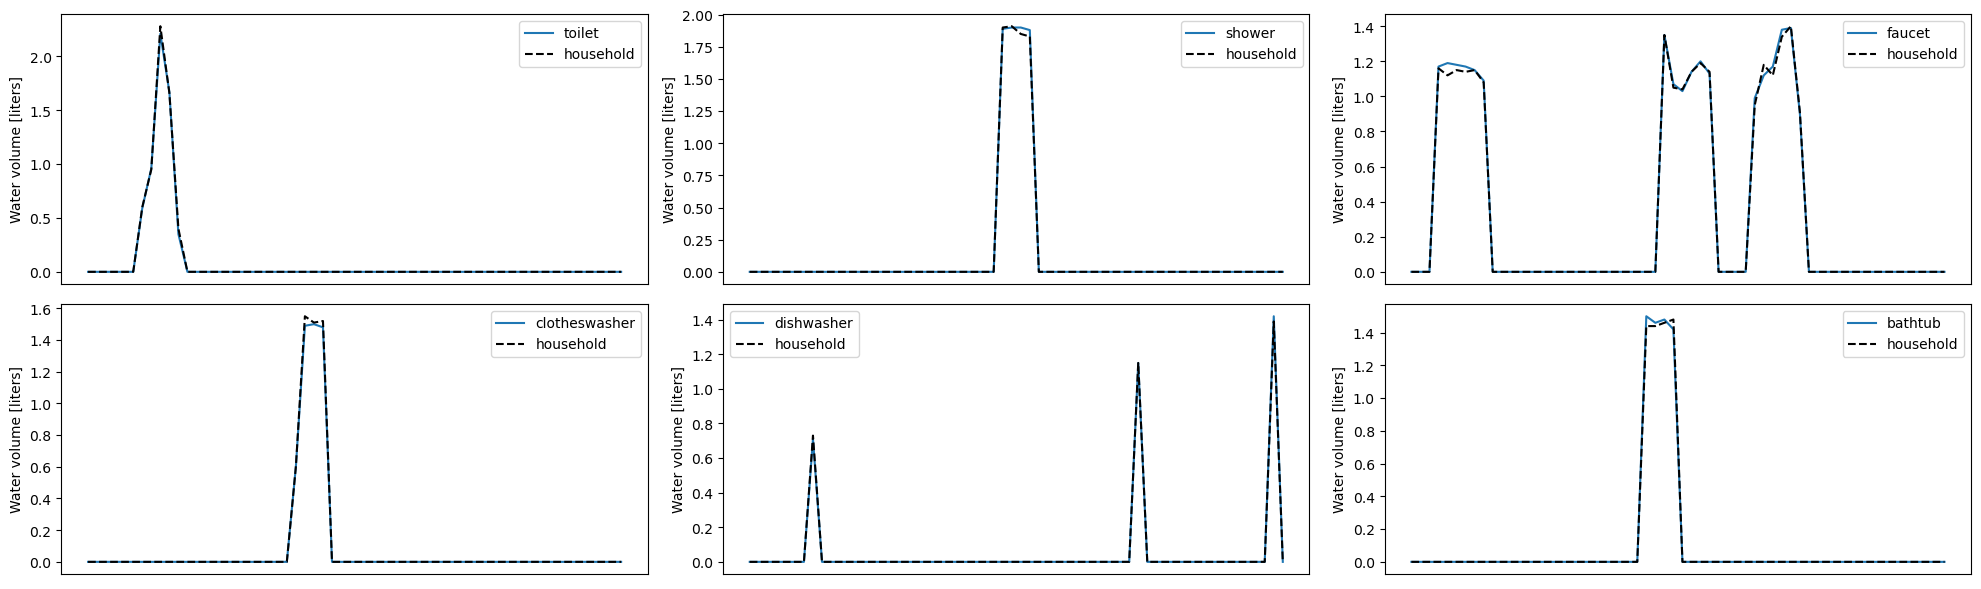

In [8]:
# choose random seed
np.random.seed(424242)

# initialize figure with subplots
f, axes = plt.subplots(2,3, figsize=(20,6))

# grouped dataset 
temp = df.groupby('episode').sum()[end_uses]

for ax, end_use in zip(axes.reshape(-1),end_uses):
  # select one episode at random for each end_use
  episodes_with_end_use = temp[temp[end_use]>0].index.tolist()
  episode = np.random.choice(episodes_with_end_use)
  df.groupby('episode').get_group(episode)[end_use].plot(label=end_use, ax=ax);
  df.groupby('episode').get_group(episode)['household'].plot(ls='--', c='k', label='household', ax=ax);
  ax.set_xticks([])  
  ax.set_ylabel('Water volume [liters]')
  ax.legend()
f.tight_layout()

You can see that measurments taken locally for each end-use differ slightly from the recordings at household level. This is because the flow sensors and smart water meter are different instruments, with different accuracies and subject to different noise.

Let's now check if there is only 1 water end-use for each episode and let's check how many epsisodes are related to each type of end-use. This can be perfomed, for instance, after creating an auxiliary dataframe by grouping the original dataset by each episode and summing and individual water consumptions together within each episode. 


<sub>_Note:_ Is not important if you do not understand everything the code below; focus on the visualizeed results.</sub>

In [9]:
temp = df.groupby('episode')[end_uses].sum()
temp.head()

,toilet,shower,faucet,clotheswasher,dishwasher,bathtub
episode,,,,,,
1,6.95,0.0,0.00,0.00,0.0,0.00
6,0.00,0.0,0.00,2.63,0.0,0.00
21,0.00,0.0,0.00,3.09,0.0,0.00
37,0.00,0.0,0.00,0.00,0.0,7.13
141,0.00,0.0,9.12,0.00,0.0,0.00


Now we check whether each cell is greater than zero and by summing instances row-wise and column-wise we can answer the two questions. You can do this by specifying the correct axis.

toilet           14205
shower           12577
faucet           19687
clotheswasher    12147
dishwasher       11573
bathtub           6849
dtype: int64


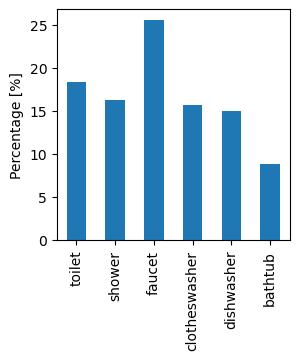

In [10]:
# check if we only have one end use for each episode
(temp>0).sum(axis=1).unique()

# check water end use distribution 
print((temp>0).sum(axis=0))
n_episodes = len(temp)
(((temp>0).sum(axis=0)/n_episodes)*100).plot(kind='bar', figsize=(3,3))
plt.gca().set_ylabel('Percentage [%]');

We now know that we have exactly a single end use for each recorded episode, and that we have a slightly unbalanced datasets: *faucets* are more represented than the remaining items. *Bathub* events are less common than the others.

#### Creation of training, validation and test datasets.

We now create the final datasets that you will be using for this assignment. You are tasked with identifying end-uses by their signature as recorded by the smart water meter during each episode. As such, each input entry of your dataset will be a **sequence** of lenght $L = 60$, while outputs are **one-hot encoded vectors** with all zeros apart from the appliance/end-use

<sub>_Note:_ Is not important if you do not understand everything the code below. Just make use correctly of the datasets for the remainder of your assignment.</sub>

In [12]:
def create_dataset(df):
  # group each episode (they will be sorted automatically based on current order)
  df_grouped = df.groupby('episode')
  X,Y = [],[]
  for group_name, df_group in df_grouped:
    x = df_group.household.values
    X.append(x)
    y = df_group[end_uses].values
    Y.append(y.sum(axis=0)>0)
  X = np.array(X)
  Y = np.array(Y)
  return X,Y

# tra = training, val = validation (early stopping), tst = testing (unseen)
L = 60 # 10 minutes episode length, sampled every 10 seconds
X,Y = create_dataset(df)
Xtra,Xval,Ytra,Yval = train_test_split(X,Y,test_size=0.25,shuffle=False)
Xval,Xtst,Yval,Ytst = train_test_split(Xval,Yval,test_size=0.5,shuffle=False)

print(f"X.shape for training is: {Xtra.shape}, Y.shape for training is: {Ytra.shape}")
print(f"X.shape for validation is: {Xval.shape}, Y.shape for validation is: {Yval.shape}")
print(f"X.shape for test is: {Xtst.shape}, Y.shape for test is: {Ytst.shape}")

X.shape for training is: (57778, 60), Y.shape for training is: (57778, 6)
X.shape for validation is: (9630, 60), Y.shape for validation is: (9630, 6)
X.shape for test is: (9630, 60), Y.shape for test is: (9630, 6)


## Arash added part
fit_transorm is used just for training data set but for applying on validation (cross-validation), and test, min and max of training data set is applied on validation and test to reflect the training dataset

In [13]:
# rescale input dataset (no need for outputs as they are are one-hot-encoded classes)
Sx=MinMaxScaler()
Xtra = Sx.fit_transform(Xtra)
Xval = Sx.transform(Xval)
Xtst = Sx.transform(Xtst) 

### Beginning of assignment!

#### Part 1. <u> Train a Feed-forward Neural Network that will be used as benchmark</u>.

You are asked to train several FNNs architectures (between 5 and 10) in order to identify a good benchmark for the *water end-use multiclass classification problem*. The benchmark model will be refined later in the assignment. 

_Instructions_
- Try single layer as well as double layer FNNs;
- Limit the total number of neurons in each layer to 100;
- Use dropout and early stopping (callback) to reduce overfitting;
- Limit training epochs to 200 and use time stopping (callback) to reduce computational time to a max of 5 minutes for each model;
- Use the Adam optimizer, and set learning rate to 0.010;
- Use a batch size of 256.

_Questions_
- For each trained architecture, store the *best value for the validation loss*, *number of trainable parameters*, and *training time*;
- Select the benchmark architecture and motivate why. This FNN will be refined later along with the most promising RNN architecture.
- Plot the training/validation history of the selected FNN architecture

In [75]:
def FNNmodel(neurons_per_layer =[100], dropout_rate=0.2, kernel_initializer='normal'):
    
    '''
    neurons_per_layer : a list containing the number of neuron for each hidden layer.
    dropout : The dropout rate is set to 20%, meaning one in five inputs will be randomly excluded from each update cycle.
    regularization = L1 regularization penalizes the sum of absolute values of the weights, whereas L2 regularization penalizes
    the sum of squares of the weights
    '''
    i = Input(shape=(L,) , name='Input')
    #creting the hidden layers
    
    #Arash added:
    #for hidden layers Relu activation is used because it is faster for hidden layer
    for index,neurons in enumerate(neurons_per_layer):
        #if there is just one hidden layer
        if index == 0:
            x = Dense(neurons, activation='relu',kernel_initializer='normal',name = 'hidden_layer')(i)
            x = Dropout(dropout_rate , name = 'droupout')(x)
        #for more than one hidden layer
        else :
            x = Dense(neurons, activation='relu' , kernel_initializer='normal', name= 'hidden_layer2')(x)
            x = Dropout(dropout_rate,name = 'droupout2')(x)
    #Arash added
    # if the classification is binary, the sigmoid function is used. otherwise, Softmax for multiclass classification.
    x = Dense(6, activation='softmax', name='Output')(x)
    model = Model(i,x)
    
    return model

In [82]:
# create model combinations (using itertools product)

#just ANN model is used
ANN_type = ['FNN']
#different layers with different number of neurons can be considered
neurons =[[100],[100,100]]
dropout_rate = [0 ,0.2]
lr = [0.010]
batch_size = [256]
init_mode = ['uniform', 'normal']

all_combinations = list(itertools.product(*[ANN_type,neurons,dropout_rate,lr,batch_size,init_mode]))
print(pd.DataFrame(data=all_combinations, columns=['ANN_type','neurons','dropout_rate','lr','batch_size','init_mode']))

res_df_fnn = pd.DataFrame(index=np.arange(len(all_combinations)), 
                      columns=['ANN_type','neurons','dropout_rate','lr','batch_size','model_name','init_mode',
                               'tr_loss','val_loss','tr_acc','val_acc','elapsed_time','trainable_params'])

rs = [] # histories

for i, combination in enumerate(all_combinations):
  # extract parameters and create model name  
  ANN_type, neurons, dropout_rate, lr, batch_size, init_mode = combination
  model_name = f"{ANN_type}_neurons={neurons}_dropout={dropout_rate}_lr={lr}_bsize={batch_size},_initializedp={init_mode}"

    
  # store in res_df 
  res_df_fnn.loc[i,['ANN_type','neurons', 'dropout_rate','lr','batch_size','initializedp','model_name']] = combination + (model_name,)

  # call backs
  earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1,  min_delta=1e-6, mode='auto')
  timeStopping = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)  
  callbacks = [earlyStopping, timeStopping]

  #create model
  model = FNNmodel(neurons, kernel_initializer=init_mode,dropout_rate=dropout_rate)
  print(model.summary())

  # compile
  model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

  # echo screen
  print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')
  # train
  start_time = time.time()
  r = model.fit(Xtra, Ytra, epochs=200, validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=batch_size)
  rs.append(r)
  # store results
  res_df_fnn.loc[i,'elapsed_time'] = time.time() - start_time
  best_ix = np.array(r.history['val_loss']).argmin()
  res_df_fnn.loc[i,['tr_loss','val_loss','tr_acc','val_acc']] = [r.history['loss'][best_ix],r.history['val_loss'][best_ix],
                                                                 r.history['accuracy'][best_ix],r.history['val_accuracy'][best_ix]]     
  res_df_fnn.loc[i,'trainable_params'] = get_trainable_params(model)
  print(res_df_fnn.loc[i,['elapsed_time','val_loss','val_acc']])

  ANN_type     neurons  dropout_rate    lr  batch_size init_mode
0      FNN       [100]           0.0  0.01         256   uniform
1      FNN       [100]           0.0  0.01         256    normal
2      FNN       [100]           0.2  0.01         256   uniform
3      FNN       [100]           0.2  0.01         256    normal
4      FNN  [100, 100]           0.0  0.01         256   uniform
5      FNN  [100, 100]           0.0  0.01         256    normal
6      FNN  [100, 100]           0.2  0.01         256   uniform
7      FNN  [100, 100]           0.2  0.01         256    normal
Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 60)]              0         
                                                                 
 hidden_layer (Dense)        (None, 100)               6100      
                                                                 
 

C:\Users\amaleki1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Epoch 107: early stopping
elapsed_time    33.950307
val_loss         0.873224
val_acc          0.616096
Name: 0, dtype: object
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 60)]              0         
                                                                 
 hidden_layer (Dense)        (None, 100)               6100      
                                                                 
 droupout (Dropout)          (None, 100)               0         
                                                                 
 Output (Dense)              (None, 6)                 606       
                                                                 
Total params: 6,706
Trainable params: 6,706
Non-trainable params: 0
_________________________________________________________________
None
Training FNN_neurons=[100]_dropout=0_lr=0.01_bsize=256,_

                                                                 
 hidden_layer (Dense)        (None, 100)               6100      
                                                                 
 droupout (Dropout)          (None, 100)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 100)               10100     
                                                                 
 dropout_25 (Dropout)        (None, 100)               0         
                                                                 
 Output (Dense)              (None, 6)                 606       
                                                                 
Total params: 16,806
Trainable params: 16,806
Non-trainable params: 0
_________________________________________________________________
None
Training FNN_neurons=[100, 100]_dropout=0.2_lr=0.01_bsize=256,_initializedp=normal, #8 of 8
Epoch 115: early stopping
elapsed_time   

In [83]:
#to compare the result of the trained models
res_df_fnn.sort_values(by='val_loss')

,ANN_type,neurons,dropout_rate,lr,batch_size,model_name,init_mode,tr_loss,val_loss,tr_acc,val_acc,elapsed_time,trainable_params,initializedp
6,FNN,"[100, 100]",0.2,0.01,256,"FNN_neurons=[100, 100]_dropout=0.2_lr=0.01_bsi...",NaN,0.857493,0.827161,0.608311,0.628245,96.850173,16806,uniform
7,FNN,"[100, 100]",0.2,0.01,256,"FNN_neurons=[100, 100]_dropout=0.2_lr=0.01_bsi...",NaN,0.875882,0.828419,0.601752,0.630841,71.111254,16806,normal
4,FNN,"[100, 100]",0,0.01,256,"FNN_neurons=[100, 100]_dropout=0_lr=0.01_bsize...",NaN,0.76713,0.851448,0.651528,0.623468,28.710525,16806,uniform
5,FNN,"[100, 100]",0,0.01,256,"FNN_neurons=[100, 100]_dropout=0_lr=0.01_bsize...",NaN,0.779576,0.853146,0.647565,0.627414,24.219251,16806,normal
0,FNN,[100],0,0.01,256,"FNN_neurons=[100]_dropout=0_lr=0.01_bsize=256,...",NaN,0.798688,0.873224,0.641074,0.616096,33.950307,6706,uniform
1,FNN,[100],0,0.01,256,"FNN_neurons=[100]_dropout=0_lr=0.01_bsize=256,...",NaN,0.811727,0.874023,0.636055,0.625857,32.102534,6706,normal
3,FNN,[100],0.2,0.01,256,FNN_neurons=[100]_dropout=0.2_lr=0.01_bsize=25...,NaN,0.889204,0.875049,0.59758,0.603634,71.168859,6706,normal
2,FNN,[100],0.2,0.01,256,FNN_neurons=[100]_dropout=0.2_lr=0.01_bsize=25...,NaN,0.914869,0.887464,0.580775,0.594808,41.891296,6706,uniform


## Arash added part
The lower the loss, the better a model (unless the model has over-fitted to the training data). The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets.
Loss value implies how well or poorly a certain model behaves after each iteration of optimization. Ideally, one would expect the reduction of loss after each, or several, iteration(s).  
The accuracy of a model is usually determined after the model parameters are learned and fixed and no learning is taking place. Then the test samples are fed to the model and the number of mistakes (zero-one loss) the model makes are recorded, after comparison to the true targets. Then the percentage of misclassification is calculated.

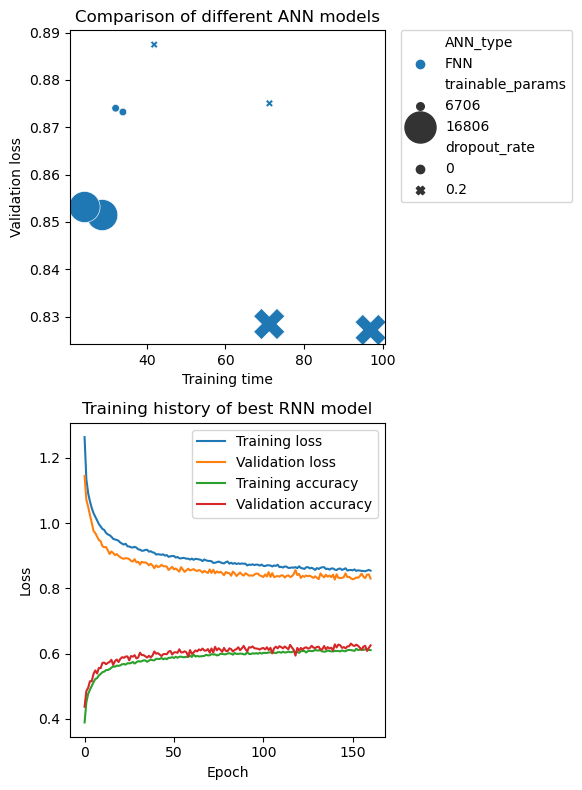

In [84]:
f, axes = plt.subplots(2,1,figsize=(6,8))
sns.scatterplot(
    data=res_df_fnn, x="elapsed_time", y="val_loss", hue="ANN_type", style="dropout_rate", size="trainable_params", sizes=(30, 500), ax=axes[0]);
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_title('Comparison of different ANN models')
axes[0].set_xlabel('Training time')
axes[0].set_ylabel('Validation loss')

best_model_ix = res_df_fnn['val_loss'].astype(float).idxmin();
axes[1].plot(rs[best_model_ix].history['loss'],label='Training loss');
axes[1].plot(rs[best_model_ix].history['val_loss'],label='Validation loss');
axes[1].plot(rs[best_model_ix].history['accuracy'],label='Training accuracy');
axes[1].plot(rs[best_model_ix].history['val_accuracy'],label='Validation accuracy');

axes[1].set_title('Training history of best RNN model');
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
f.tight_layout()

#### Part 2. <u> Train multiple Recurrent Neural Networks architectures</u>.

You are asked to train several preliminary RNNs architectures (between 6 and 18) to identify a suitable recurrent architecture for *water end-use multiclass classification*. The most promising RNN model will be refined later in the assignment. 

_Instructions_
- Try SimpleRNN as well as LSTM;
- Limit the total number of neurons to 100;
- Try both Unidirectional as well as Bidirectional RNNs;
- Use dropout and early stopping (callback) to reduce overfitting;
- Limit training epochs to 200 and use time stopping (callback) to reduce computational time to a max of 5 minutes for each model;
- Use the Adam optimizer, and set learning rate to 0.010;
- Use a batch size of 256.

_Questions_
- For each trained architecture, store the *best value for the validation loss*, *number of trainable parameters*, and *training time*;
- Select the most promising architecture and motivate why. This RNN will be refined later and compared against the benchmark FNN model you developed in the previous section.
- Plot the training/validation history of the selected RNN architecture;



In [85]:
def RNNmodel(n_hidden_neurons=100, ann_type='LSTM', kernel_initializer='normal', Unidirectional=True , dropout_rate=0.2 ):
    '''
    this function is use for having the general for of the RNN models.
    '''
    i = Input(shape=(L,1))
    if ann_type == 'SimpleRNN' and  Unidirectional == True:
        x = SimpleRNN(n_hidden_neurons, activation='tanh', kernel_initializer='normal',return_sequences=False, name='SimpleRNN')(i)
    elif ann_type == 'SimpleRNN' and  Unidirectional == False:
        x = Bidirectional(SimpleRNN(n_hidden_neurons, activation='tanh', kernel_initializer='normal', return_sequences=False, name='SimpleRNN'))(i)
    elif ann_type == 'LSTM' and Unidirectional == True:
        x = LSTM(n_hidden_neurons, activation='tanh',kernel_initializer='normal', name='LSTM')(i)
    elif ann_type == 'LSTM' and Unidirectional == False:
        x = Bidrectional(LSTM(n_hidden_neurons, activation='tanh',kernel_initializer='normal', name='LSTM'))(i)
    
    else:
        raise Exception("Error: Cell type not recognized! Choose between 'SimpleRNN','LSTM'.")    
    x = Dropout(dropout_rate , name='dropout')(x)
    x = Dense(6, activation='softmax', name='Output')(x)
    model = Model(i,x)
    return model


In [88]:
# create model combinations (using itertools product)
ANN_type = ['SimpleRNN','LSTM']
neurons = [100]
dropout_rate = [0,0.2]
unidirectional = [True,False]
lr = [0.01]
batch_size = [256]
init_mode = ['uniform', 'normal']


all_combinations = list(itertools.product(*[ANN_type,neurons,dropout_rate,unidirectional,init_mode,lr,batch_size]))
print(pd.DataFrame(data=all_combinations, columns=['Ann_type','neurons','dropout_rate','unidirectional','init_mode','lr','batch_size']))


res_df_rnn = pd.DataFrame(index=np.arange(len(all_combinations)), 
                      columns=['Ann_type','neurons','dropout_rate','unidirectional','init_mode','lr','batch_size','model_name',
                               'tr_loss','val_loss','tr_acc','val_acc','elapsed_time','trainable_params'])

rs = [] # histories

for i, combination in enumerate(all_combinations):
  # extract parameters and create model name  
  ANN_type, neurons, dropout_rate,unidirectional,init_mode, lr, batch_size = combination
  model_name = f"{ANN_type}_neurons={neurons}_dropout={dropout_rate}_lr={lr}_bsize={batch_size}_unidirectional={unidirectional}_initializedp={init_mode}"

    
  # store in res_df 
  res_df_rnn.loc[i,['Ann_type','neurons','dropout_rate','unidirectional','init_mode','lr','batch_size','model_name']] = combination + (model_name,)

  # call backs
  earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,  min_delta=1e-6, mode='auto' , restore_best_weights=True)
  timeStopping = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)  
  callbacks = [earlyStopping, timeStopping]

  #create model
  model = RNNmodel(neurons, ann_type=ANN_type, Unidirectional=True,kernel_initializer='normal' , dropout_rate=0.2  )
  print(model.summary())


  # compile
  model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

  # echo screen
  print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')
  # train
  start_time = time.time()
  r = model.fit(Xtra, Ytra, epochs=200, validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=batch_size)
  rs.append(r)
  # store results
  res_df_rnn.loc[i,'elapsed_time'] = time.time() - start_time
  best_ix = np.array(r.history['val_loss']).argmin()
  res_df_rnn.loc[i,['tr_loss','val_loss','tr_acc','val_acc']] = [r.history['loss'][best_ix],r.history['val_loss'][best_ix],
                                                                 r.history['accuracy'][best_ix],r.history['val_accuracy'][best_ix]]     
  res_df_rnn.loc[i,'trainable_params'] = get_trainable_params(model)
  print(res_df_rnn.loc[i,['elapsed_time','val_loss','val_acc']])

     Ann_type  neurons  dropout_rate  unidirectional init_mode    lr  \
0   SimpleRNN      100           0.0            True   uniform  0.01   
1   SimpleRNN      100           0.0            True    normal  0.01   
2   SimpleRNN      100           0.0           False   uniform  0.01   
3   SimpleRNN      100           0.0           False    normal  0.01   
4   SimpleRNN      100           0.2            True   uniform  0.01   
5   SimpleRNN      100           0.2            True    normal  0.01   
6   SimpleRNN      100           0.2           False   uniform  0.01   
7   SimpleRNN      100           0.2           False    normal  0.01   
8        LSTM      100           0.0            True   uniform  0.01   
9        LSTM      100           0.0            True    normal  0.01   
10       LSTM      100           0.0           False   uniform  0.01   
11       LSTM      100           0.0           False    normal  0.01   
12       LSTM      100           0.2            True   uniform  

 Output (Dense)              (None, 6)                 606       
                                                                 
Total params: 10,806
Trainable params: 10,806
Non-trainable params: 0
_________________________________________________________________
None
Training SimpleRNN_neurons=100_dropout=0.2_lr=0.01_bsize=256_unidirectional=True_initializedp=normal, #6 of 16
Timed stopping at epoch 43 after training for 0:05:00
elapsed_time    306.659542
val_loss          1.649111
val_acc           0.379751
Name: 5, dtype: object
Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 SimpleRNN (SimpleRNN)       (None, 100)               10200     
                                                                 
 dropout (Dropout)           (None, 100)    

 LSTM (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 Output (Dense)              (None, 6)                 606       
                                                                 
Total params: 41,406
Trainable params: 41,406
Non-trainable params: 0
_________________________________________________________________
None
Training LSTM_neurons=100_dropout=0.2_lr=0.01_bsize=256_unidirectional=True_initializedp=uniform, #13 of 16
Timed stopping at epoch 11 after training for 0:05:00
elapsed_time    305.197982
val_loss          1.737793
val_acc           0.253375
Name: 12, dtype: object
Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 60, 1)]  

In [89]:
res_df_rnn.sort_values(by='val_loss')

,Ann_type,neurons,dropout_rate,unidirectional,init_mode,lr,batch_size,model_name,tr_loss,val_loss,tr_acc,val_acc,elapsed_time,trainable_params
8,LSTM,100,0,True,uniform,0.01,256,LSTM_neurons=100_dropout=0_lr=0.01_bsize=256_u...,0.889155,0.879437,0.599294,0.596885,315.569616,41406
14,LSTM,100,0.2,False,uniform,0.01,256,LSTM_neurons=100_dropout=0.2_lr=0.01_bsize=256...,0.960563,0.923994,0.556042,0.578505,302.723026,41406
13,LSTM,100,0.2,True,normal,0.01,256,LSTM_neurons=100_dropout=0.2_lr=0.01_bsize=256...,1.064314,0.9811,0.507131,0.551817,313.46413,41406
9,LSTM,100,0,True,normal,0.01,256,LSTM_neurons=100_dropout=0_lr=0.01_bsize=256_u...,1.138611,1.115651,0.446571,0.457321,319.703838,41406
11,LSTM,100,0,False,normal,0.01,256,LSTM_neurons=100_dropout=0_lr=0.01_bsize=256_u...,1.238261,1.164993,0.392,0.410488,303.89197,41406
10,LSTM,100,0,False,uniform,0.01,256,LSTM_neurons=100_dropout=0_lr=0.01_bsize=256_u...,1.674219,1.411646,0.287635,0.37757,309.770133,41406
15,LSTM,100,0.2,False,normal,0.01,256,LSTM_neurons=100_dropout=0.2_lr=0.01_bsize=256...,1.691817,1.419805,0.26787,0.368536,314.113433,41406
5,SimpleRNN,100,0.2,True,normal,0.01,256,SimpleRNN_neurons=100_dropout=0.2_lr=0.01_bsiz...,1.764692,1.649111,0.239399,0.379751,306.659542,10806
12,LSTM,100,0.2,True,uniform,0.01,256,LSTM_neurons=100_dropout=0.2_lr=0.01_bsize=256...,1.746482,1.737793,0.255322,0.253375,305.197982,41406
7,SimpleRNN,100,0.2,False,normal,0.01,256,SimpleRNN_neurons=100_dropout=0.2_lr=0.01_bsiz...,1.770675,1.743623,0.230866,0.251506,302.739556,10806


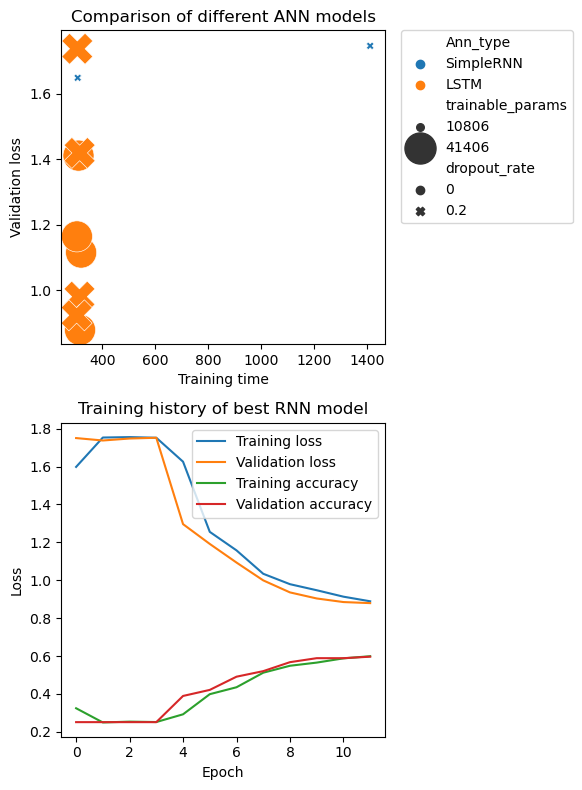

In [90]:
f, axes = plt.subplots(2,1,figsize=(6,8))
sns.scatterplot(
    data=res_df_rnn, x="elapsed_time", y="val_loss", hue="Ann_type", style="dropout_rate", size="trainable_params", sizes=(30, 500), ax=axes[0]);
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_title('Comparison of different ANN models')
axes[0].set_xlabel('Training time')
axes[0].set_ylabel('Validation loss')

best_model_ix_rnn = res_df_rnn['val_loss'].astype(float).idxmin();
axes[1].plot(rs[best_model_ix_rnn].history['loss'],label='Training loss');
axes[1].plot(rs[best_model_ix_rnn].history['val_loss'],label='Validation loss');
axes[1].plot(rs[best_model_ix_rnn].history['accuracy'],label='Training accuracy');
axes[1].plot(rs[best_model_ix_rnn].history['val_accuracy'],label='Validation accuracy');

axes[1].set_title('Training history of best RNN model');
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
f.tight_layout()

#### Part 3. <u> Refine and compare the best FNN and RNN</u>.

You are asked to refine the most promising architectures of Part 1 and Part 2 to develop a more accurate *water end-use multiclass classification* model. The classification performance of the best of the two refined models will be assessed in the last part of the assignment. 

_Instructions_
- Retrain the best FNN and best RNN of Part 1 and Part 2;
- Use _dropout_ and the _early stopping_ callback to reduce overfitting;
- Use _ModelCheckpoint_ callback to save the best model for each architecture (weights only);
- Use _ReduceLRonPlateau_ or _LearningRateScheduler_ callbacks to reduce the learning rate dynamically as the training progresses;
- Limit training epochs to 1000 and use the TimeStopping callback to reduce computational time to a max of 15 minutes for each model;
- Use the _Adam_ optimizer, and set the _learning rate_ to 0.005;
- Use a _batch size_ of 256.

_Questions_
- For each trained architecture, store the *best value for the validation loss* and *training time*;
- Plot the training/validation history of both models, including the evolution of the learning rate;
- Select the best model based on performances, and explain why.



In [150]:
best_ix_rnn = res_df_rnn['val_loss'].astype(float).idxmin()
ANN_type,neurons,dropout_rate,unidirectional,initializedp = res_df_rnn.loc[best_ix_rnn][['Ann_type','neurons','dropout_rate','unidirectional','init_mode']]
print(f'the best model for RNN has {neurons},the dropout{dropout_rate},the unidirectional is {unidirectional},the initialized parameter is {init_mode}')



best_ix_fnn = res_df_fnn['val_loss'].astype(float).idxmin()
ANN_type_fnn,neurons_fnn,dropout_rate_fnn,initializedp = res_df_fnn.loc[best_ix_fnn][['ANN_type','neurons','dropout_rate','init_mode']]
print(f'the best model for FNN has {neurons_fnn},the dropout is {dropout_rate_fnn}, the initialized parameter is {init_mode}')


the best model for RNN has 100,the dropout0,the unidirectional is True,the initialized parameter is normal
the best model for FNN has [100, 100],the dropout is 0.2, the initialized parameter is normal


In [141]:
def scheduler(epoch, lr):
  if epoch%50==0:
    lr = 0.005
  else:
    lr = lr * tf.math.exp(-0.01)
  return lr

# LearningRateScheduler
from tensorflow.keras.callbacks import LearningRateScheduler

lrScheduler = LearningRateScheduler(scheduler)

In [144]:

earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,  min_delta=5e-5, mode='auto')
timeStopping = tfa.callbacks.TimeStopping(seconds=15*60, verbose=1)  
lrScheduler = LearningRateScheduler(scheduler)
#The Hierarchical Data Format (HDF5) is a data storage format for storing large arrays of data
#, including values for the weights in a neural network.
modelCheckpoint = ModelCheckpoint('RNN_model_weights.hdf5', save_best_only=True, monitor='val_loss', 
                                  mode='auto', save_weights_only=True)

callbacks = [earlyStopping, timeStopping ,modelCheckpoint ,lrScheduler]

#create model
model_name = f"{ANN_type}_neurons={neurons}_dropout={dropout_rate}_lr={lr}_bsize={batch_size}_unidirectional={unidirectional}_initializedp={init_mode}"
print(model_name)
model = RNNmodel(neurons, ann_type=ANN_type, Unidirectional=unidirectional,kernel_initializer=initializedp , dropout_rate=dropout_rate)
print(model.summary())


# compile
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])


r_rnn_refined = model.fit(Xtra, Ytra, epochs=1000, validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=256)
# store results
res_df_rnn.loc[1,'elapsed_time'] = time.time() - start_time
best_ix = np.array(r_rnn_refined.history['val_loss']).argmin()
res_df_rnn.loc[1,['tr_loss','val_loss','tr_acc','val_acc']] = [r_rnn_refined.history['loss'][best_ix],r_rnn_refined.history['val_loss'][best_ix],
                                                               r_rnn_refined.history['accuracy'][best_ix],r_rnn_refined.history['val_accuracy'][best_ix]]     
res_df_rnn.loc[1,'trainable_params'] = get_trainable_params(model)
print(res_df_rnn.loc[1,['elapsed_time','val_loss','val_acc']])

LSTM_neurons=100_dropout=0_lr=0.01_bsize=256_unidirectional=True_initializedp=normal
Model: "model_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 60, 1)]           0         
                                                                 
 LSTM (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 Output (Dense)              (None, 6)                 606       
                                                                 
Total params: 41,406
Trainable params: 41,406
Non-trainable params: 0
_________________________________________________________________
None
Timed stopping at epoch 17 after training for 0:15:00
elapsed_time    9668.119459
val_loss      

In [152]:

earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,  min_delta=5e-5, mode='auto')
timeStopping = tfa.callbacks.TimeStopping(seconds=15*60, verbose=1)  
lrScheduler = LearningRateScheduler(scheduler)
modelCheckpoint = ModelCheckpoint('FNN_model_weights.hdf5', save_best_only=True, monitor='val_loss', 
                                  mode='auto', save_weights_only=True)

callbacks = [earlyStopping, timeStopping ,modelCheckpoint,lrScheduler]

#create model
model = FNNmodel(neurons_fnn, kernel_initializer=initializedp ,dropout_rate=dropout_rate_fnn)
print(model.summary())


# compile
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# train

r_fnn_refined = model.fit(Xtra, Ytra, epochs=1000, validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=256)
# store results
res_df_fnn.loc[1,'elapsed_time'] = time.time() - start_time
best_ix = np.array(r_fnn_refined.history['val_loss']).argmin()
res_df_fnn.loc[1,['tr_loss','val_loss','tr_acc','val_acc']] = [r_fnn_refined.history['loss'][best_ix],r_fnn_refined.history['val_loss'][best_ix],
                                                               r_fnn_refined.history['accuracy'][best_ix],r_fnn_refined.history['val_accuracy'][best_ix]]     
res_df_fnn.loc[1,'trainable_params'] = get_trainable_params(model)
print(res_df_fnn.loc[1,['elapsed_time','val_loss','val_acc']])

Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 60)]              0         
                                                                 
 hidden_layer (Dense)        (None, 100)               6100      
                                                                 
 droupout (Dropout)          (None, 100)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 100)               10100     
                                                                 
 dropout_29 (Dropout)        (None, 100)               0         
                                                                 
 Output (Dense)              (None, 6)                 606       
                                                                 
Total params: 16,806
Trainable params: 16,806
Non-trainabl

Text(0, 0.5, 'Learning rate')

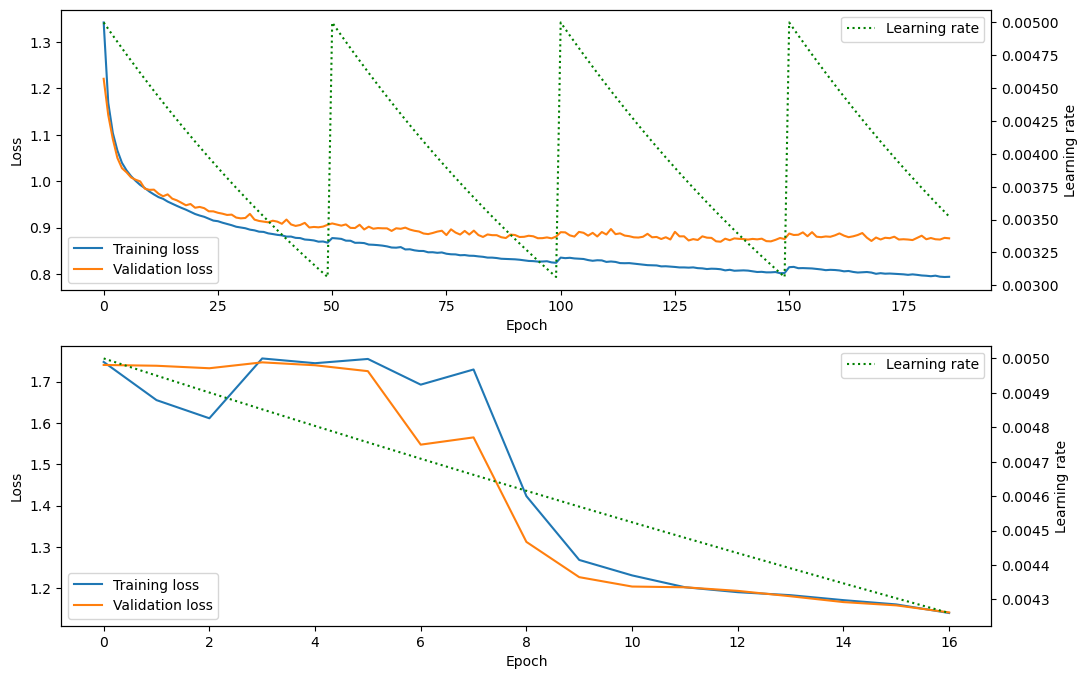

In [145]:
f, axes = plt.subplots(2,1,figsize=(12,8))
# plot results for FNN
axes[0].plot(r_fnn_refined.history['loss'],label='Training loss')
axes[0].plot(r_fnn_refined.history['val_loss'],label='Validation loss')
ax20 = axes[0].twinx()
# instantiate a second axes that shares the same x-axis
ax20.plot(r_fnn_refined.history['lr'],ls=':',color='green',label='Learning rate')
axes[0].legend(loc=3)
ax20.legend(loc=1)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
ax20.set_ylabel('Learning rate')

axes[1].plot(r_rnn_refined.history['loss'],label='Training loss')
axes[1].plot(r_rnn_refined.history['val_loss'],label='Validation loss')
ax20 = axes[1].twinx()
# instantiate a second axes that shares the same x-axis
ax20.plot(r_rnn_refined.history['lr'],ls=':',color='green',label='Learning rate')
axes[1].legend(loc=3)
ax20.legend(loc=1)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
ax20.set_ylabel('Learning rate')


#### Part 4. <u> Check performances of best ANN on the test dataset </u>.

You are asked to check the classification performances of the best, refined, ANN you trained. 

_Instructions_
- Load the best model weights for the best architecture (saved via ModelCheckpoint) in Part 3;
- Compute predictions on the test dataset;  

_Tasks_
- Plot/print the *confusion matrix* for the test dataset (ground truth vs predictions);
- Print the *classification report* for the test dataset;
- Comment the results. Does the model perform well enough to be employed? Are performances equal across the different classes? If not, why? What are possible causes of misclassification? (note: visualizing typical signatures, like done at the beginning of the notebook might be helpful).



301/301 [==============================] - 0s 577us/step
Normalized confusion matrix
[[4.90315440e-01 1.06806862e-01 3.68013282e-01 5.53403431e-03
  3.87382402e-03 2.54565578e-02]
 [8.25396825e-03 7.32063492e-01 1.84761905e-01 2.53968254e-03
  1.26984127e-03 7.11111111e-02]
 [1.15122343e-01 1.66064982e-01 7.10790213e-01 4.01123145e-04
  1.60449258e-03 6.01684717e-03]
 [2.39948119e-02 1.81582361e-02 2.20492866e-02 6.04409857e-01
  3.17769131e-01 1.36186770e-02]
 [1.29124821e-02 4.30416069e-03 5.73888092e-03 2.18077475e-01
  7.48206600e-01 1.07604017e-02]
 [2.68620269e-02 2.47863248e-01 8.66910867e-02 6.10500611e-03
  1.22100122e-02 6.20268620e-01]]
Confusion matrix, without normalization
[[ 886  193  665   10    7   46]
 [  13 1153  291    4    2  112]
 [ 287  414 1772    1    4   15]
 [  37   28   34  932  490   21]
 [  18    6    8  304 1043   15]
 [  22  203   71    5   10  508]]
              precision    recall  f1-score   support

           0       0.70      0.49      0.58      1

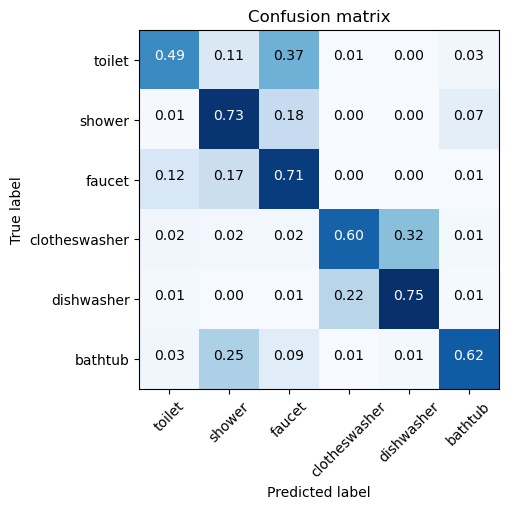

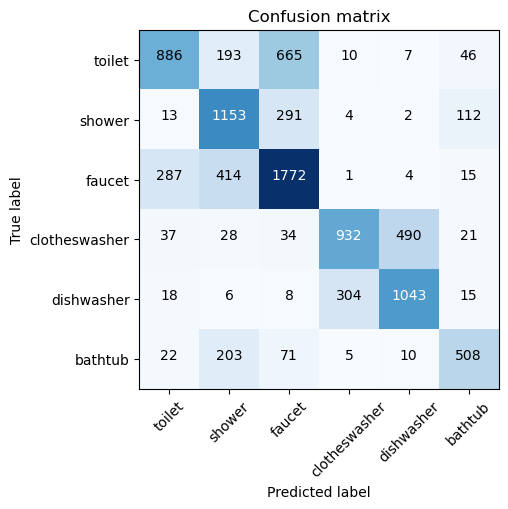

In [153]:
# load best model
model.load_weights('FNN_model_weights.hdf5')
Ytst_pred = model.predict(Xtst).argmax(axis=1)
cm = confusion_matrix(Ytst.argmax(axis=1), Ytst_pred)
plot_confusion_matrix(cm, end_uses,normalize=True)

plot_confusion_matrix(cm, end_uses,normalize=False)
print(classification_report(Ytst.argmax(axis=1), Ytst_pred))

## Arash added part
it can be seen that bathtub recorded data and shower is close to eachother so it can be one of the reason for miss classiication

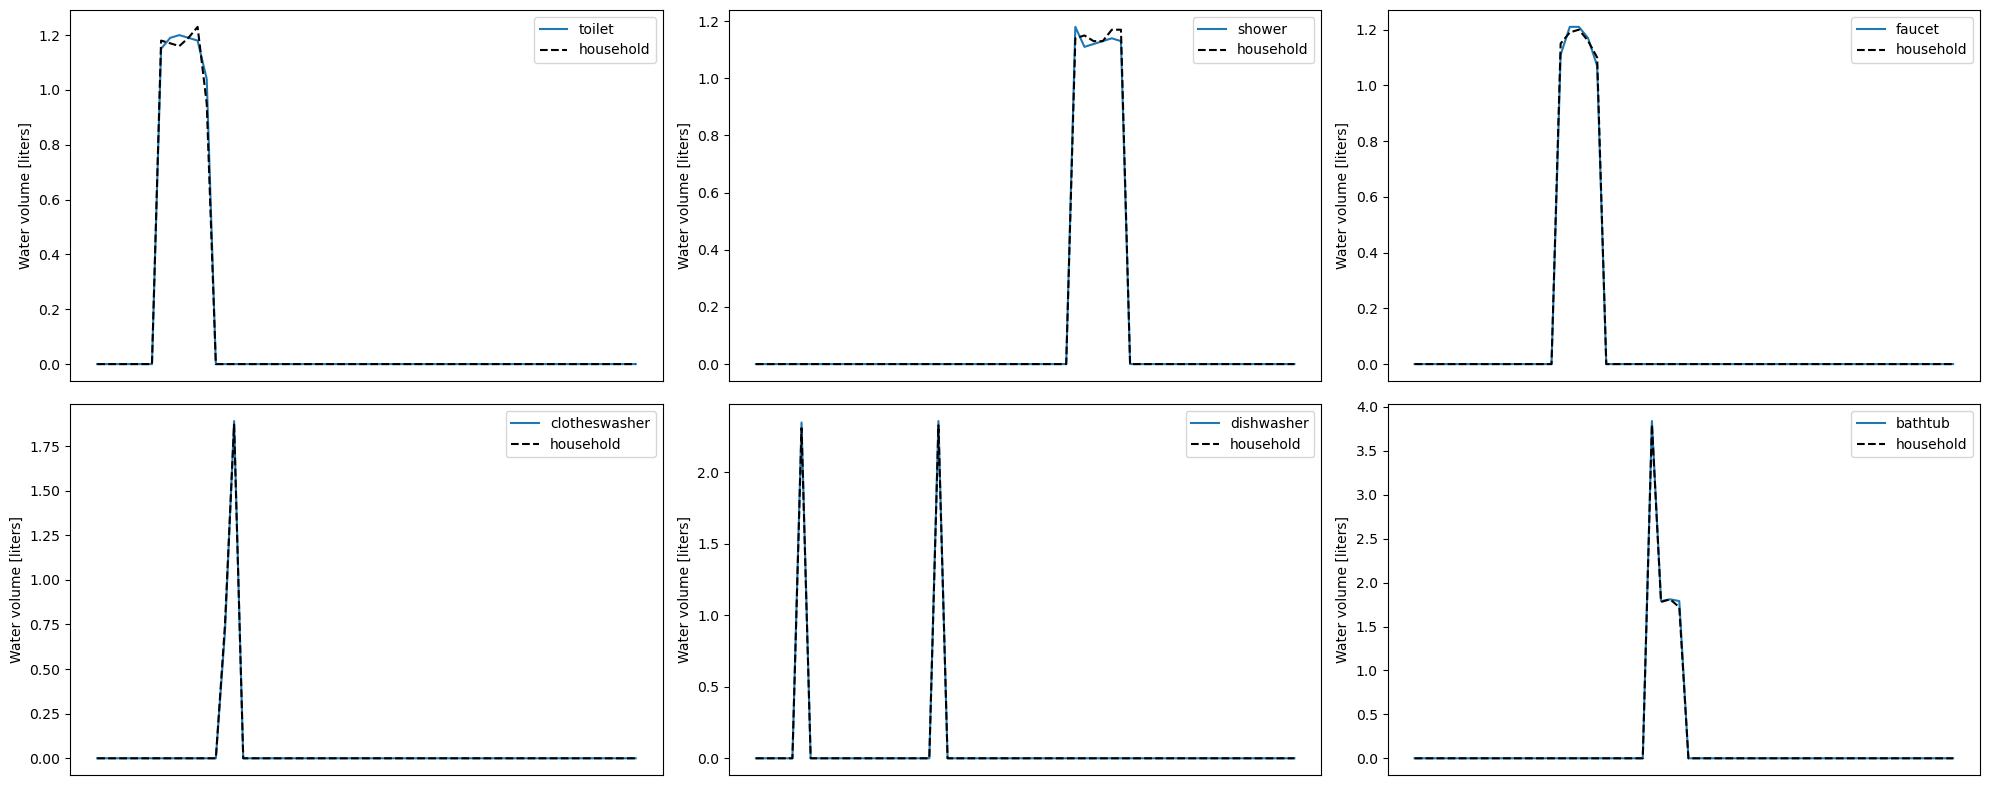

In [156]:
# choose random seed
np.random.seed(121)

# initialize figure with subplots
f, axes = plt.subplots(2,3, figsize=(20,8))

# grouped dataset 
temp = df.groupby('episode').sum()[end_uses]

for ax, end_use in zip(axes.reshape(-1),end_uses):
  # select one episode at random for each end_use
  episodes_with_end_use = temp[temp[end_use]>0].index.tolist()
  episode = np.random.choice(episodes_with_end_use)
  df.groupby('episode').get_group(episode)[end_use].plot(label=end_use, ax=ax);
  df.groupby('episode').get_group(episode)['household'].plot(ls='--', c='k', label='household', ax=ax);
  ax.set_xticks([])  
  ax.set_ylabel('Water volume [liters]')
  ax.legend()
f.tight_layout()